In [1]:
import numpy as np
import lmdb
import caffe
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%pylab inline

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_PATH = '/Users/reneoctavio/Documents/leafsnap/bvlc_googlenet/'
DATASET_PATH = '/Users/reneoctavio/Documents/leafsnap/'
SNAPSHOT_PATH = '/Volumes/Windows/Snapshots/leafsnap/bvlc_googlenet/'

MODEL_FILE = MODEL_PATH + 'deploy.prototxt'
PRETRAINED = SNAPSHOT_PATH + 'bvlc_googlenet_quick_iter_50000.caffemodel'
CAT_FILE = DATASET_PATH + 'species.txt'
VALIDSET_FILE = DATASET_PATH + 'validset.txt'
MEAN_FILE = DATASET_PATH + 'leafsnap_mean.npy'

#Read Categories
sp_file = open(CAT_FILE, 'r')
dicCat = {}
for line in sp_file:
    ln = line.split()
    num = int(ln[len(ln) - 1])
    name = ' '.join(ln[0:(len(ln)-1)])
    dicCat[num] = name

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Input a image for testing
TEST_IMAG = '/Volumes/Windows/Leafsnap/new-lmdb/treated/4397.jpg'
# Image class
label = 12

In [2]:
# Create network
caffe.set_mode_cpu()
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(MEAN_FILE).mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [3]:
# Read image
image = caffe.io.load_image(TEST_IMAG)

# Resize the image to the standard (256, 256) and oversample net input sized crops.
input_oversampled = caffe.io.oversample([caffe.io.resize_image(image, (256, 256))], (224, 224))
# 'data' is the input blob name in the model definition, so we preprocess for that input.
caffe_input = np.asarray([transformer.preprocess('data', in_) for in_ in input_oversampled])

# set net to batch size of 10
net.blobs['data'].reshape(10,3,224,224)

net.blobs['data'].data[...] = caffe_input
out = net.forward()

predictions = out['prob']
print(predictions[0].argsort()[-5:][::-1])
print(predictions[1].argsort()[-5:][::-1])
print(predictions[2].argsort()[-5:][::-1])
print(predictions[3].argsort()[-5:][::-1])
print(predictions[4].argsort()[-5:][::-1])
print(predictions[5].argsort()[-5:][::-1])
print(predictions[6].argsort()[-5:][::-1])
print(predictions[7].argsort()[-5:][::-1])
print(predictions[8].argsort()[-5:][::-1])
print(predictions[9].argsort()[-5:][::-1])
predictions = predictions.reshape((len(predictions) / 10, 10, -1))
predictions = predictions.mean(1)
predictions = predictions[0]
print(predictions.shape)
predictions = predictions.argsort()[-5:][::-1]
print(predictions)
predictedArr5 = []
for cls in predictions:
    predictedArr5.append(cls)
    print(dicCat[cls])

predictedArr5 = np.array(predictedArr5)
 
print(predictedArr5)
print('\nTrue Class: ' + dicCat[label])

[12  8 79  7  2]
[ 12   8  79   7 124]
[12  8 79  7 78]
[ 12   8  79   7 124]
[ 12   8  79   7 124]
[12  8 79  2  7]
[ 12   8  79 124   7]
[12  8 79  2  7]
[ 12   8  79 124   7]
[ 12   8  79   2 124]
(185,)
[12  8 79  2  7]
Acer saccharum
Acer platanoides
Liriodendron tulipifera
Acer campestre
Acer pensylvanicum
[12  8 79  2  7]

True Class: Acer saccharum


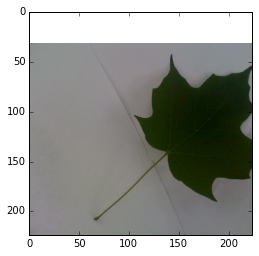

In [5]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))